# Vulnerability Data Exploratory Analysis

This notebook provides a comprehensive exploratory analysis of vulnerability data from 
the Common Vulnerabilities and Exposures (CVE) and the National Vulnerability Database (NVD). 

The analysis focuses on:

1. **Data Quality Assessment**: Understanding missing values, data types, and overall structure
2. **Temporal Analysis**: Examining vulnerability trends over time
3. **CVSS Version Analysis**: Comparing different CVSS scoring versions (2.0, 3.0, 3.1, 4.0)
4. **Target Labeling**: Identifying vulnerabilities that are known to be exploited in the wild
5. **Data Preparation**: Creating a cleaned dataset for machine learning models

## Dataset Overview
The dataset contains vulnerability information including:
- CVE identifiers
- CVSS scores (base, exploit, impact)
- Vulnerability descriptions
- Attack vectors and complexity metrics
- Temporal information extracted from CVE IDs


In [39]:
import pandas as pd

# Load the vulnerabilities dataset
# This dataset contains Common Vulnerabilities and Exposures (CVE) data with CVSS scores
df = pd.read_csv('../vulnerabilities.csv')

print("Dataset shape:", df.shape)
print("\nLast 5 rows of the dataset:")
print(df.tail())

/var/folders/f4/0fj7b3nx5nsbzrqrpd58r8br0000gn/T/ipykernel_76767/2148025000.py:5: DtypeWarning: Columns (26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../vulnerabilities.csv')


Dataset shape: (404790, 54)

Last 5 rows of the dataset:
        Unnamed: 0              id  baseScoreAv  exploitScoreAv  \
404785       13446  CVE-2025-28410          9.8             3.9   
404786       13447  CVE-2025-28943          5.9             1.7   
404787       13448  CVE-2025-28406          9.8             3.9   
404788       13449  CVE-2025-28902          4.3             2.8   
404789       13450  CVE-2025-28144          6.5             3.9   

        impactScoreAv  baseScoreMax  exploitScoreMax  impactScoreMax  version  \
404785            5.9           9.8              3.9             5.9      3.1   
404786            3.7           5.9              1.7             3.7      3.1   
404787            5.9           9.8              3.9             5.9      3.1   
404788            1.4           4.3              2.8             1.4      3.1   
404789            2.5           6.5              3.9             2.5      3.1   

                                        vectorString 

## Initial Data Exploration

Let's start by examining the vulnerability descriptions to understand the nature of the data we're working with. The description field contains natural language text describing each vulnerability, which will be valuable for our analysis.


In [40]:
# Examine the description field to understand the nature of vulnerability descriptions
print("Sample vulnerability descriptions:")
print(df['description'].tail())

Sample vulnerability descriptions:
404785    An issue in RUoYi v.4.8.0 allows a remote atta...
404786    Improper Neutralization of Input During Web Pa...
404787    An issue in RUoYi v.4.8.0 allows a remote atta...
404788    Cross-Site Request Forgery (CSRF) vulnerabilit...
404789    Edimax AC1200 Wave 2 Dual-Band Gigabit Router ...
Name: description, dtype: object


### Data Cleaning

The dataset contains an auto-generated index column 'Unnamed: 0' that we need to remove. This is a common artifact when CSV files are saved with pandas default settings.


In [41]:
# Remove the auto-generated index column that was created during CSV export
df = df.drop(columns=['Unnamed: 0'])

print("Dataset after removing unnamed index column:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Dataset after removing unnamed index column:
Shape: (404790, 53)

First 5 rows:
              id  baseScoreAv  exploitScoreAv  impactScoreAv  baseScoreMax  \
0  CVE-1999-0217          5.0            10.0            2.9           5.0   
1  CVE-1999-0702         10.0            10.0           10.0          10.0   
2  CVE-1999-0352          7.2             3.9           10.0           7.2   
3  CVE-1999-0978          7.5            10.0            6.4           7.5   
4  CVE-1999-0581         10.0            10.0           10.0          10.0   

   exploitScoreMax  impactScoreMax  version                vectorString  \
0             10.0             2.9      2.0  AV:N/AC:L/Au:N/C:N/I:N/A:P   
1             10.0            10.0      2.0  AV:N/AC:L/Au:N/C:C/I:C/A:C   
2              3.9            10.0      2.0  AV:L/AC:L/Au:N/C:C/I:C/A:C   
3             10.0             6.4      2.0  AV:N/AC:L/Au:N/C:P/I:P/A:P   
4             10.0            10.0      2.0  AV:N/AC:L/Au:N/C:C/I:C/A:C   



### Data Quality Assessment

Understanding the completeness of our dataset is crucial for analysis. Let's examine the shape of the data and identify missing values across all columns.


In [42]:
# Check the overall size of our dataset
print(f"Dataset dimensions: {df.shape}")
print(f"Total vulnerabilities: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]:,}")

Dataset dimensions: (404790, 53)
Total vulnerabilities: 404,790
Total features: 53


In [43]:
# Analyze missing values across all columns
# This helps us understand data quality and which features might be incomplete
null_counts = df.isnull().sum()
print("Missing values per column:")
print(null_counts)

# Calculate percentage of missing values
print(f"\nColumns with significant missing data (>10% missing):")
missing_percentage = (null_counts / len(df)) * 100
significant_missing = missing_percentage[missing_percentage > 10]
for col, pct in significant_missing.items():
    print(f"{col}: {pct:.1f}% missing")

Missing values per column:
id                                        0
baseScoreAv                               0
exploitScoreAv                         6391
impactScoreAv                          6391
baseScoreMax                              0
exploitScoreMax                        6391
impactScoreMax                         6391
version                                   0
vectorString                              0
baseSeverity                         186366
attackVector                         186366
attackComplexity                     186366
privilegesRequired                   186366
userInteractions                     404790
scope                                192757
confidentialityImpact                  6391
integrityImpact                        6391
availabilityImpact                     6391
numScores                                 0
agreement                                 0
accessVector                         218424
accessComplexity                     218424
authe

## Temporal Analysis

CVE identifiers follow a standardized format: CVE-YYYY-NNNN, where YYYY represents the year. This allows us to extract temporal information and analyze how data completeness has evolved over time. Understanding this temporal pattern is crucial because:

1. **CVSS Evolution**: Different CVSS versions were introduced at different times
2. **Data Collection Changes**: The NVD's data collection practices have evolved
3. **Scoring Completeness**: Newer vulnerabilities may have more complete scoring information

Let's visualize missing data patterns across years to understand these temporal dynamics.


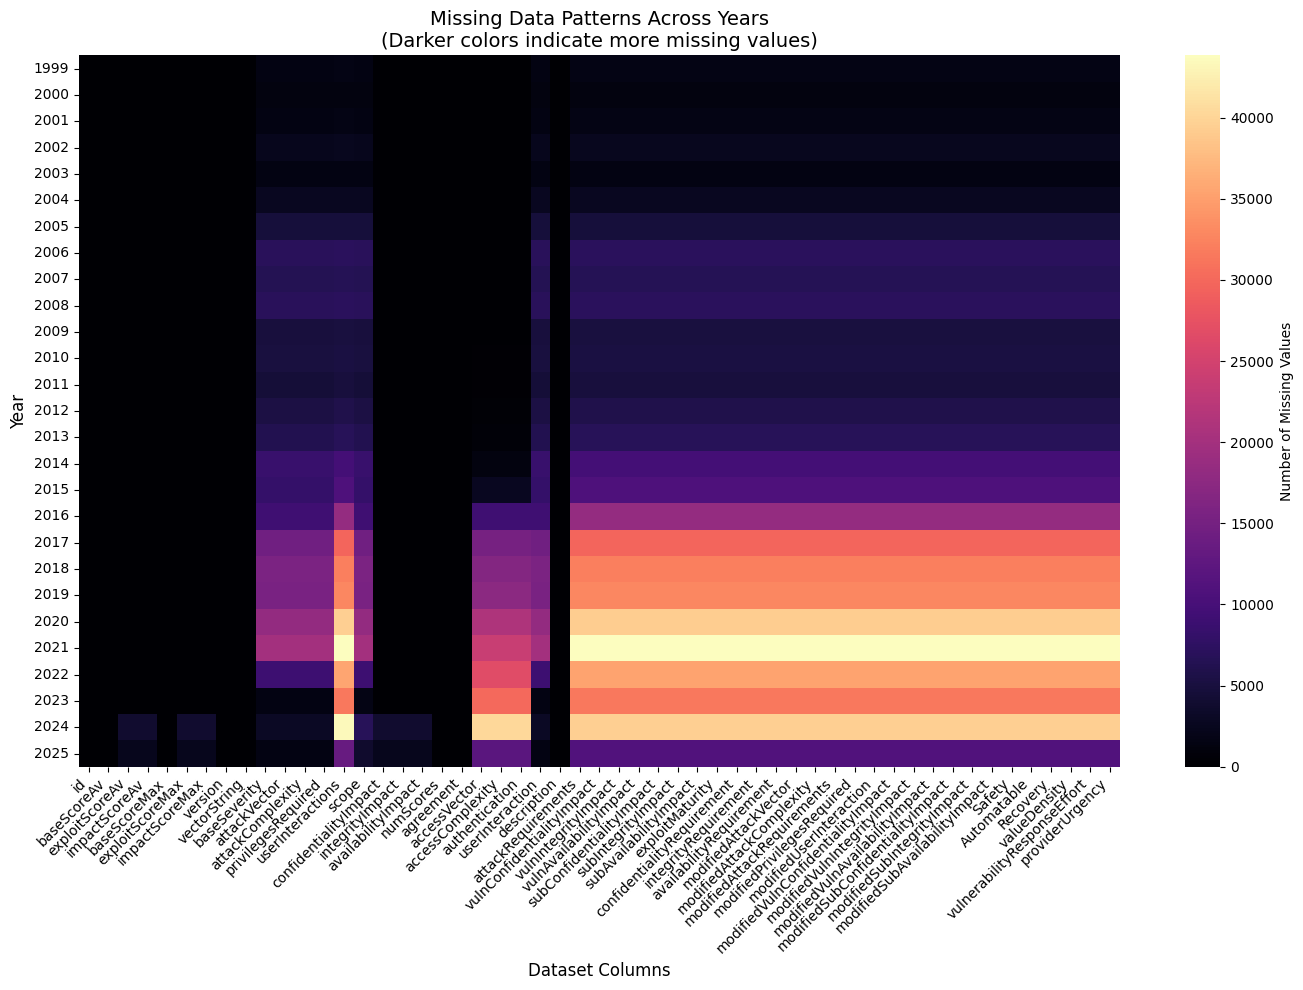

Key insights from the heatmap:
- Missing data patterns vary significantly across years
- Some columns are consistently missing for certain time periods
- This reflects the evolution of CVSS scoring standards over time


In [44]:
# Create a heatmap showing missing data patterns across years
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the year from CVE identifiers (format: CVE-YYYY-NNNN)
df['year'] = df['id'].str.extract(r'CVE-(\d{4})-')[0].astype(int)

# Group by year and count missing values for each column
# This reveals how data completeness has changed over time
null_counts_by_year = df.groupby('year').apply(lambda x: x.isnull().sum(), include_groups=False)

# Create the heatmap visualization
plt.figure(figsize=(14, 10))
sns.heatmap(null_counts_by_year, cmap='magma', cbar_kws={'label': 'Number of Missing Values'})
plt.title('Missing Data Patterns Across Years\n(Darker colors indicate more missing values)', fontsize=14)
plt.xlabel('Dataset Columns', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Key insights from the heatmap:")
print("- Missing data patterns vary significantly across years")
print("- Some columns are consistently missing for certain time periods")
print("- This reflects the evolution of CVSS scoring standards over time")

### Vulnerability Trends Over Time

Understanding the volume of vulnerabilities disclosed each year provides insight into:
- The growth of cybersecurity threats
- Increased awareness and reporting
- Changes in software development practices
- Industry-wide security initiatives

Note: We exclude 2025 data as it's incomplete (only partial year data available).


 Over Time

Understanding the volume of vulnerabilities disclosed each year provides insight into:
- The growth of cybersecurity threats
- Increased awareness and reporting
- Changes in software development practices
- Industry-wide security initiatives

Note: We exclude 2025 data as it's incomplete (only partial year data available).


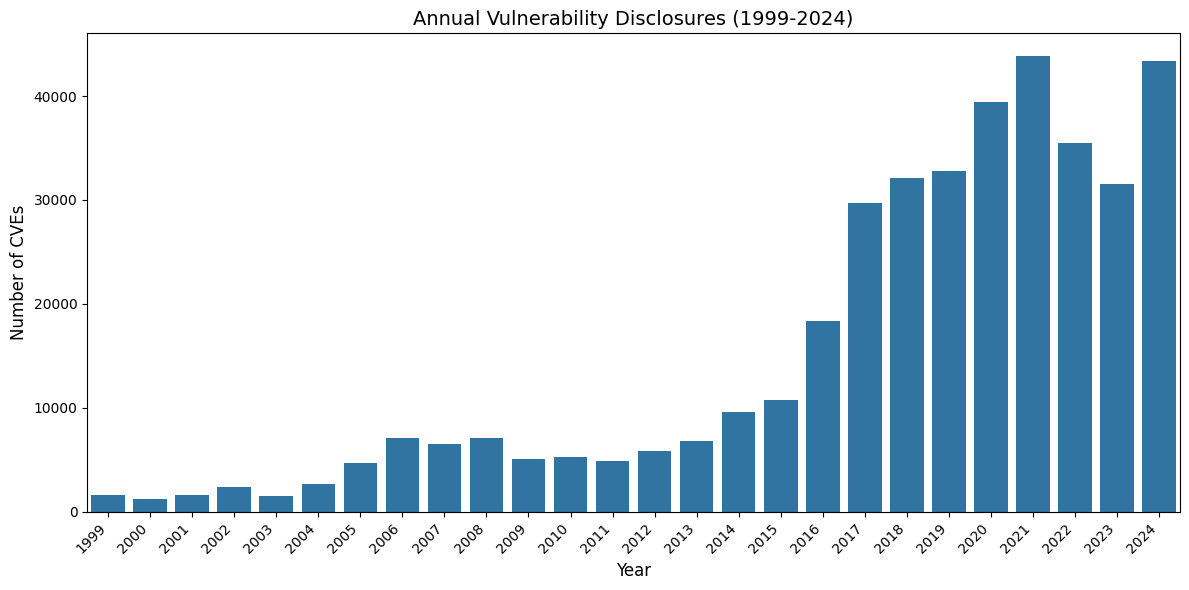


Vulnerability Disclosure Trends:
Total vulnerabilities (1999-2024): 391,339
Average per year: 15052
Peak year: 2021 with 43,844 vulnerabilities
Recent years (2020-2024) average: 38712 per year


In [45]:
# Visualize vulnerability disclosure trends over time
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out 2025 data as it's incomplete (partial year)
df_filtered = df[df['year'] != 2025]

# Create vulnerability count visualization
plt.figure(figsize=(12, 6))
sns.countplot(data=df_filtered, x='year')
plt.title('Annual Vulnerability Disclosures (1999-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of CVEs', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate and display key statistics
recent_years = df_filtered[df_filtered['year'] >= 2020]
print(f"\nVulnerability Disclosure Trends:")
print(f"Total vulnerabilities (1999-2024): {len(df_filtered):,}")
print(f"Average per year: {len(df_filtered) / len(df_filtered['year'].unique()):.0f}")
print(f"Peak year: {df_filtered['year'].value_counts().index[0]} with {df_filtered['year'].value_counts().iloc[0]:,} vulnerabilities")
print(f"Recent years (2020-2024) average: {len(recent_years) / len(recent_years['year'].unique()):.0f} per year")

In [46]:
# Trim the data so that there is only one entry for each CVE in the data set. 

print(f"Original DataFrame shape: {df.shape}")

# This selects all rows except those with the specified version
df_trimmed = df_filtered[df_filtered['version'] != 4.0].copy()
print(f"DataFrame shape after dropping version '4.0': {df_trimmed.shape}")

# This effectively keeps the first 'version' associated with that 'id'
df_trimmed = df_trimmed.drop_duplicates(subset=['id'], keep='last')
print("Filtered DataFrame shape (keeping first version per CVE):", df_trimmed.shape)

Original DataFrame shape: (404790, 54)
DataFrame shape after dropping version '4.0': (387316, 54)
Filtered DataFrame shape (keeping first version per CVE): (264411, 54)


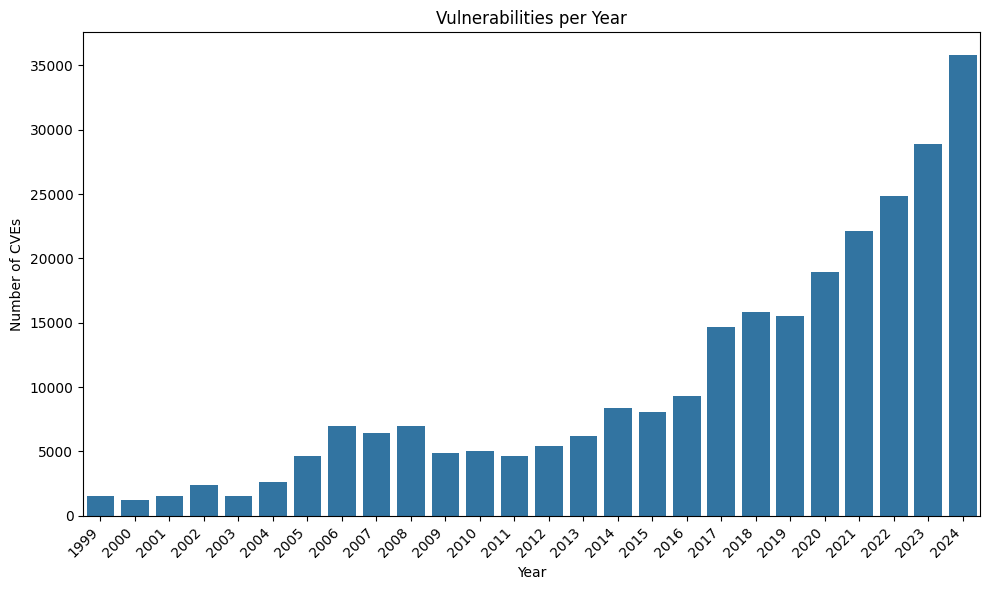

In [47]:
# Create a bar chart of the CVEs per year using the trimmed data. 
plt.figure(figsize=(10, 6))
sns.countplot(data=df_trimmed, x='year')
plt.title('Vulnerabilities per Year')
plt.xlabel('Year')
plt.ylabel('Number of CVEs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Using the trimmed data we can better see that the number of CVEs is growing for each progressive year in the data set and this trend is more clear. 

In [48]:
# Display detailed missing data statistics by year
print("Missing data counts by year (showing trends in data completeness):")
print(null_counts_by_year)

# Identify years with significant changes in data completeness
print("\nKey observations about data completeness evolution:")
print("- Early years (1999-2004): Basic scoring information available")
print("- Mid-period (2005-2015): Gradual improvement in data completeness")  
print("- Recent years (2016+): More comprehensive scoring with newer CVSS versions")
print("- 2024-2025: Highest missing values due to transition to CVSS 4.0 and incomplete data")

Missing data counts by year (showing trends in data completeness):
      id  baseScoreAv  exploitScoreAv  impactScoreAv  baseScoreMax  \
year                                                                 
1999   0            0               0              0             0   
2000   0            0               0              0             0   
2001   0            0               0              0             0   
2002   0            0               0              0             0   
2003   0            0               0              0             0   
2004   0            0               0              0             0   
2005   0            0               1              1             0   
2006   0            0               0              0             0   
2007   0            0               0              0             0   
2008   0            0               0              0             0   
2009   0            0               0              0             0   
2010   0            0  

## Data Export and Preprocessing

Before diving deeper into analysis, let's examine the columns in our dataset and prepare separate datasets for specific analysis tasks. We'll also create a descriptions-only dataset for text analysis purposes.


In [49]:
# Display all column names to understand our dataset structure
print("Dataset columns:")
print(df.columns.tolist())
print(f"\nTotal columns: {len(df.columns)}")

# Note: We keep the 'year' column as it's useful for temporal analysis

Dataset columns:
['id', 'baseScoreAv', 'exploitScoreAv', 'impactScoreAv', 'baseScoreMax', 'exploitScoreMax', 'impactScoreMax', 'version', 'vectorString', 'baseSeverity', 'attackVector', 'attackComplexity', 'privilegesRequired', 'userInteractions', 'scope', 'confidentialityImpact', 'integrityImpact', 'availabilityImpact', 'numScores', 'agreement', 'accessVector', 'accessComplexity', 'authentication', 'userInteraction', 'description', 'attackRequirements', 'vulnConfidentialityImpact', 'vulnIntegrityImpact', 'vulnAvailabilityImpact', 'subConfidentialityImpact', 'subIntegrityImpact', 'subAvailabilityImpact', 'exploitMaturity', 'confidentialityRequirement', 'integrityRequirement', 'availabilityRequirement', 'modifiedAttackVector', 'modifiedAttackComplexity', 'modifiedAttackRequirements', 'modifiedPrivilegesRequired', 'modifiedUserInteraction', 'modifiedVulnConfidentialityImpact', 'modifiedVulnIntegrityImpact', 'modifiedVulnAvailabilityImpact', 'modifiedSubConfidentialityImpact', 'modifiedSu

In [50]:
# Extract vulnerability descriptions for text analysis
# This creates a focused dataset for natural language processing tasks
descriptions_df = df[['id', 'description']].copy()

# Save the descriptions dataset - useful for text mining and keyword extraction
# descriptions_df.to_csv('../descriptions.csv', index=False)

#print(f"Descriptions dataset created with {len(descriptions_df)} entries")
print("Columns:", descriptions_df.columns.tolist())

Columns: ['id', 'description']


In [51]:
# Display sample of the descriptions dataset
print("Sample descriptions:")
print(descriptions_df.head())

Sample descriptions:
              id                                        description
0  CVE-1999-0217  Malicious option settings in UDP packets could...
1  CVE-1999-0702  Internet Explorer 5.0 and 5.01 allows remote a...
2  CVE-1999-0352  ControlIT 4.5 and earlier (aka Remotely Possib...
3  CVE-1999-0978  htdig allows remote attackers to execute comma...
4  CVE-1999-0581  The HKEY_CLASSES_ROOT key in a Windows NT syst...


In [52]:
# Verify the descriptions dataset dimensions
print(f"Descriptions dataset shape: {descriptions_df.shape}")
print(f"This contains {descriptions_df.shape[0]:,} vulnerability descriptions")

Descriptions dataset shape: (404790, 2)
This contains 404,790 vulnerability descriptions


In [53]:
# Confirm main dataset dimensions
print(f"Main dataset shape: {df.shape}")
print(f"Total vulnerabilities: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]:,}")

Main dataset shape: (404790, 54)
Total vulnerabilities: 404,790
Total features: 54


In [ ]:
# Export the cleaned dataset with year information added
'''
df.to_csv('../vulnerabilities_cleaned.csv', index=False)
print("Main dataset exported with year information added")
'''

Main dataset exported with year information added


## Data Type Standardization

For consistent analysis and machine learning model preparation, we need to standardize the data types of numerical columns. This ensures that all numerical features are properly formatted as floats and can be processed by mathematical operations.


In [55]:
# Standardize numerical columns to float type for consistent analysis
numerical_cols = df.select_dtypes(include=['number']).columns

print("Converting numerical columns to float type:")
print(f"Found {len(numerical_cols)} numerical columns to convert")

# Convert numerical columns to float type
converted_successfully = 0
for col in numerical_cols:
    try:
        # Attempt to convert the column to float
        df[col] = df[col].astype('float64')
        converted_successfully += 1
        print(f"✓ Converted '{col}' to float64")
    except ValueError as e:
        # Handle cases where conversion might fail (e.g., non-numeric values)
        print(f"✗ Could not convert '{col}' to float64. Error: {e}")

print(f"\nConversion Summary:")
print(f"Successfully converted: {converted_successfully}/{len(numerical_cols)} columns")

# Verify the data types after conversion
print("\nData types after standardization (numerical columns only):")
numerical_dtypes = df.select_dtypes(include=['number']).dtypes
print(numerical_dtypes)

Converting numerical columns to float type:
Found 11 numerical columns to convert
✓ Converted 'baseScoreAv' to float64
✓ Converted 'exploitScoreAv' to float64
✓ Converted 'impactScoreAv' to float64
✓ Converted 'baseScoreMax' to float64
✓ Converted 'exploitScoreMax' to float64
✓ Converted 'impactScoreMax' to float64
✓ Converted 'version' to float64
✓ Converted 'userInteractions' to float64
✓ Converted 'numScores' to float64
✓ Converted 'agreement' to float64
✓ Converted 'year' to float64

Conversion Summary:
Successfully converted: 11/11 columns

Data types after standardization (numerical columns only):
baseScoreAv         float64
exploitScoreAv      float64
impactScoreAv       float64
baseScoreMax        float64
exploitScoreMax     float64
impactScoreMax      float64
version             float64
userInteractions    float64
numScores           float64
agreement           float64
year                float64
dtype: object


## CVSS Version Analysis

The Common Vulnerability Scoring System (CVSS) has evolved through multiple versions:

- **CVSS v2.0** (2007): Original framework with base, temporal, and environmental metrics
- **CVSS v3.0** (2015): Major overhaul with improved accuracy and new metrics
- **CVSS v3.1** (2019): Refinements to v3.0 with clarified definitions
- **CVSS v4.0** (2023): Latest version with enhanced threat intelligence integration

Understanding the distribution of CVSS versions helps us:
1. Identify which scoring framework applies to different vulnerability periods
2. Understand data completeness patterns
3. Prepare for version-specific analysis

Let's reload the cleaned dataset and analyze CVSS version distribution.


In [56]:
import pandas as pd

# Reload the cleaned dataset with year information
df = pd.read_csv('../vulnerabilities_cleaned.csv')

print(f"Reloaded dataset shape: {df.shape}")
print("\nDataset sample:")
print(df.tail())

/var/folders/f4/0fj7b3nx5nsbzrqrpd58r8br0000gn/T/ipykernel_76767/276821365.py:4: DtypeWarning: Columns (25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../vulnerabilities_cleaned.csv')


Reloaded dataset shape: (404790, 54)

Dataset sample:
                    id  baseScoreAv  exploitScoreAv  impactScoreAv  \
404785  CVE-2025-28410          9.8             3.9            5.9   
404786  CVE-2025-28943          5.9             1.7            3.7   
404787  CVE-2025-28406          9.8             3.9            5.9   
404788  CVE-2025-28902          4.3             2.8            1.4   
404789  CVE-2025-28144          6.5             3.9            2.5   

        baseScoreMax  exploitScoreMax  impactScoreMax  version  \
404785           9.8              3.9             5.9      3.1   
404786           5.9              1.7             3.7      3.1   
404787           9.8              3.9             5.9      3.1   
404788           4.3              2.8             1.4      3.1   
404789           6.5              3.9             2.5      3.1   

                                        vectorString baseSeverity  \
404785  CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H     CR

In [57]:
# Analyze CVSS version distribution
print("CVSS Version Distribution:")
version_counts = df['version'].value_counts().sort_index()
print(version_counts)

# Calculate percentages
print("\nCVSS Version Percentages:")
version_percentages = (version_counts / len(df)) * 100
for version, count in version_counts.items():
    percentage = (count / len(df)) * 100
    print(f"CVSS v{version}: {count:,} vulnerabilities ({percentage:.1f}%)")

print(f"\nTotal vulnerabilities: {len(df):,}")

CVSS Version Distribution:
version
2.0    186366
3.0     53460
3.1    158573
4.0      6391
Name: count, dtype: int64

CVSS Version Percentages:
CVSS v2.0: 186,366 vulnerabilities (46.0%)
CVSS v3.0: 53,460 vulnerabilities (13.2%)
CVSS v3.1: 158,573 vulnerabilities (39.2%)
CVSS v4.0: 6,391 vulnerabilities (1.6%)

Total vulnerabilities: 404,790


In [58]:
# Verify data integrity - check for unique vulnerabilities
unique_cves = df['id'].nunique()
total_records = len(df['id'])

print(f"Data Integrity Check:")
print(f"Unique CVE IDs: {unique_cves:,}")
print(f"Total records: {total_records:,}")
print(f"Duplicate records: {total_records - unique_cves:,}")

if unique_cves == total_records:
    print("✓ All CVE IDs are unique - no duplicates found")
else:
    print("⚠ Warning: Duplicate CVE IDs found in dataset")

Data Integrity Check:
Unique CVE IDs: 275,234
Total records: 404,790
Duplicate records: 129,556
⚠ Warning: Duplicate CVE IDs found in dataset


### CVSS Version Adoption Over Time

Understanding when different CVSS versions were adopted provides insight into:
- **Transition periods**: When new versions were introduced
- **Adoption patterns**: How quickly the industry moved to newer versions
- **Data coverage**: Which vulnerabilities have scores from which versions

This analysis helps us understand the temporal distribution of different scoring frameworks.


<Figure size 1600x800 with 0 Axes>

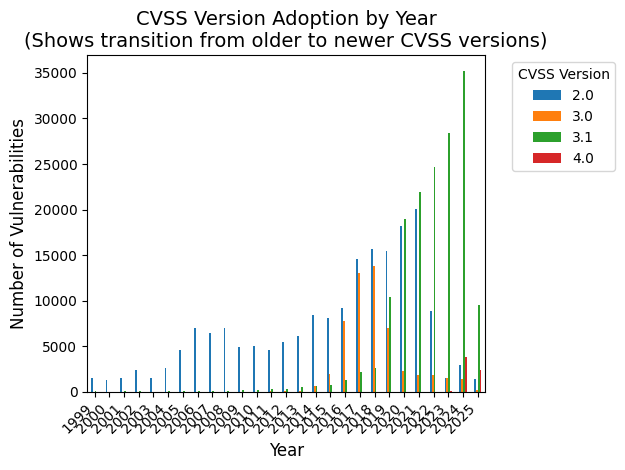

Key CVSS Version Transitions:
- CVSS v2.0: Predominant in early years
- CVSS v3.0: Introduced around 2015
- CVSS v3.1: Gradual adoption from 2019
- CVSS v4.0: Latest version introduced in 2023


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the year from CVE identifiers if not already present
if 'year' not in df.columns:
    df['year'] = df['id'].str.extract(r'CVE-(\d{4})-')[0].astype(int)

# Analyze CVSS version adoption by year
version_counts_by_year = df.groupby('year')['version'].value_counts().unstack(fill_value=0)

# Create visualization showing CVSS version adoption over time
plt.figure(figsize=(16, 8))
version_counts_by_year.plot(kind='bar', stacked=False, 
                           color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

plt.title('CVSS Version Adoption by Year\n(Shows transition from older to newer CVSS versions)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Vulnerabilities', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='CVSS Version', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display key transition points
print("Key CVSS Version Transitions:")
print("- CVSS v2.0: Predominant in early years")
print("- CVSS v3.0: Introduced around 2015")
print("- CVSS v3.1: Gradual adoption from 2019")
print("- CVSS v4.0: Latest version introduced in 2023")

In [60]:
# Display the version counts by year data table
print("CVSS Version Counts by Year:")
print(version_counts_by_year)

# Show summary statistics
print(f"\nSummary Statistics:")
print(f"Years covered: {version_counts_by_year.index.min()} - {version_counts_by_year.index.max()}")
print(f"Total years: {len(version_counts_by_year)}")
print(f"CVSS versions present: {version_counts_by_year.columns.tolist()}")

CVSS Version Counts by Year:
version    2.0    3.0    3.1   4.0
year                              
1999      1540      0     27     0
2000      1236      2     11     0
2001      1537      0     36     0
2002      2356      0     61     0
2003      1503      2     23     0
2004      2644      3     42     0
2005      4626      3     72     1
2006      6992      5     62     0
2007      6449      7     68     0
2008      7004      7     95     0
2009      4897     18    134     0
2010      5047     19    236     0
2011      4608     39    275     0
2012      5422     72    348     0
2013      6171    114    560     0
2014      8401    648    575     0
2015      8057   1927    787     0
2016      9242   7794   1339     1
2017     14537  12995   2152     7
2018     15683  13858   2588     4
2019     15444   6946  10418     2
2020     18159   2286  18929    20
2021     20020   1854  21959    11
2022      8915   1807  24721    19
2023      1524   1477  28372   127
2024      2957   1397  351

## Version-Specific Dataset Creation

To better understand the characteristics of each CVSS version, we'll create separate datasets for each version. This allows us to:

1. **Analyze version-specific metrics**: Each CVSS version has different available fields
2. **Understand data completeness**: Some versions may have more complete data than others
3. **Prepare for version-specific modeling**: Different versions may require different preprocessing approaches

Let's create separate datasets for each CVSS version.


In [61]:
# Create separate datasets for each CVSS version
# This enables version-specific analysis and understanding of data completeness
version_datasets = {}

print("Creating version-specific datasets:")
for version in sorted(df['version'].unique()):
    # Filter the original DataFrame for the current version
    # Use .copy() to avoid potential SettingWithCopyWarning
    version_datasets[version] = df[df['version'] == version].copy()
    count = len(version_datasets[version])
    print(f"CVSS v{version}: {count:,} vulnerabilities")

print(f"\nTotal datasets created: {len(version_datasets)}")
print(f"CVSS versions: {sorted(version_datasets.keys())}")

Creating version-specific datasets:
CVSS v2.0: 186,366 vulnerabilities
CVSS v3.0: 53,460 vulnerabilities
CVSS v3.1: 158,573 vulnerabilities
CVSS v4.0: 6,391 vulnerabilities

Total datasets created: 4
CVSS versions: [np.float64(2.0), np.float64(3.0), np.float64(3.1), np.float64(4.0)]


In [62]:
# Export each version-specific dataset to separate CSV files
'''
print("Exporting version-specific datasets:")
for version, subset_df in version_datasets.items():
    filename = f'../data_{version}.csv'
    subset_df.to_csv(filename, index=False)
    print(f"Exported CVSS v{version} dataset: {filename} ({len(subset_df):,} records)")

print("\nVersion-specific datasets exported successfully!")
'''

'\nprint("Exporting version-specific datasets:")\nfor version, subset_df in version_datasets.items():\n    filename = f\'../data_{version}.csv\'\n    subset_df.to_csv(filename, index=False)\n    print(f"Exported CVSS v{version} dataset: {filename} ({len(subset_df):,} records)")\n\nprint("\nVersion-specific datasets exported successfully!")\n'

In [63]:
# Load the version-specific datasets for detailed analysis
df_2 = pd.read_csv('../data_2.0.csv')
df_3 = pd.read_csv('../data_3.0.csv')
df_3_1 = pd.read_csv('../data_3.1.csv')
df_4 = pd.read_csv('../data_4.0.csv')

print("Version-specific datasets loaded:")
print(f"CVSS v2.0: {len(df_2):,} vulnerabilities")
print(f"CVSS v3.0: {len(df_3):,} vulnerabilities")
print(f"CVSS v3.1: {len(df_3_1):,} vulnerabilities")
print(f"CVSS v4.0: {len(df_4):,} vulnerabilities")

FileNotFoundError: [Errno 2] No such file or directory: '../data_2.0.csv'

### Version-Specific Missing Data Analysis

Each CVSS version has different available metrics and fields. Understanding the missing data patterns for each version helps us:

1. **Identify version-specific limitations**: Some fields may not exist in older versions
2. **Plan data preprocessing**: Different versions may require different handling approaches
3. **Assess data quality**: Some versions may have better data completeness than others

Let's create heatmaps for each version to visualize missing data patterns.


Generating missing data heatmap for CVSS v2.0...


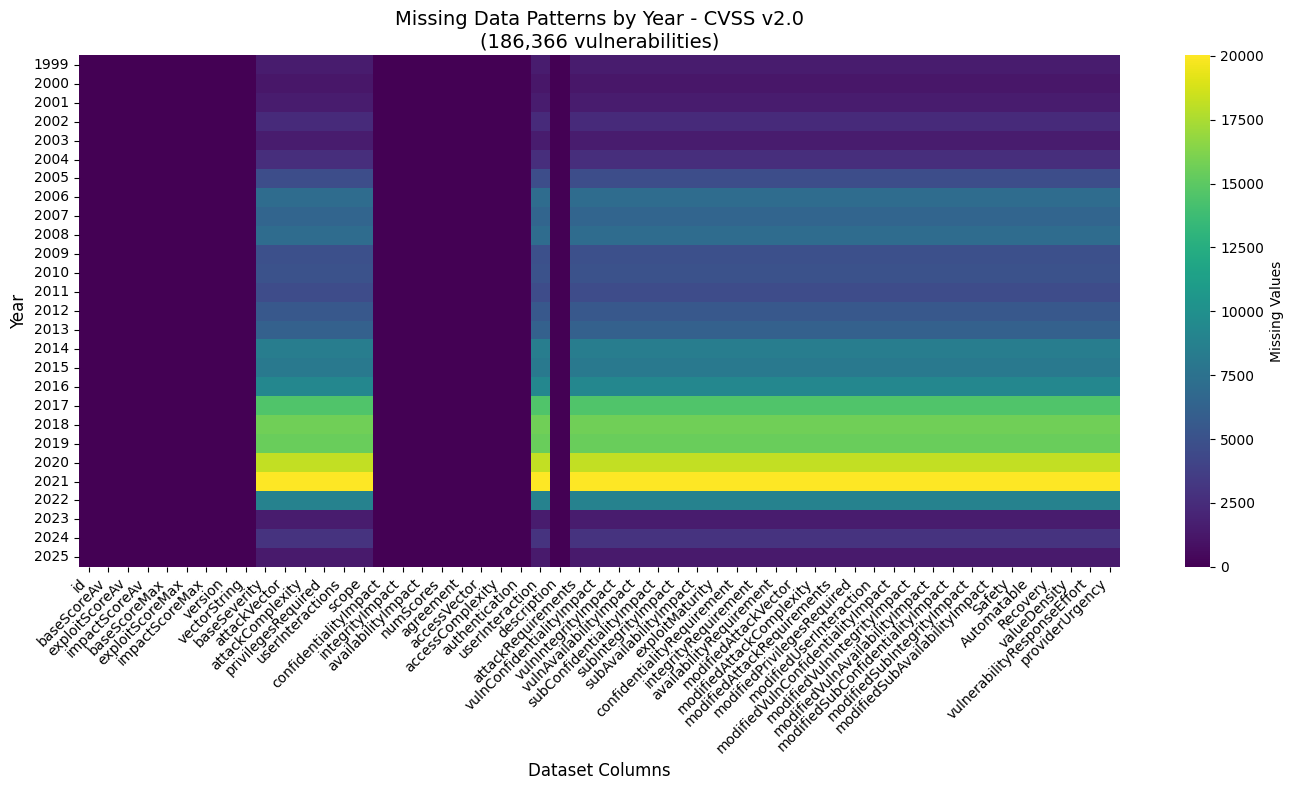

Generating missing data heatmap for CVSS v3.0...


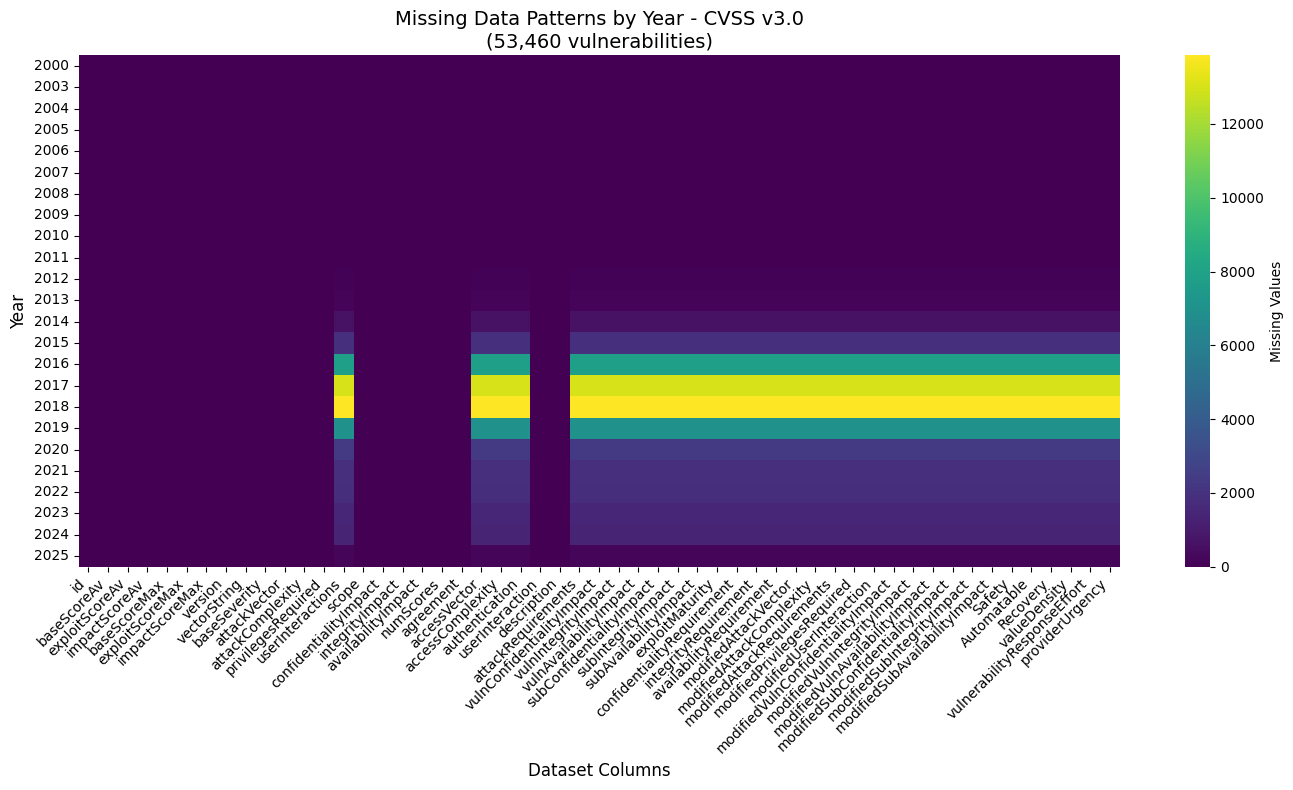

Generating missing data heatmap for CVSS v3.1...


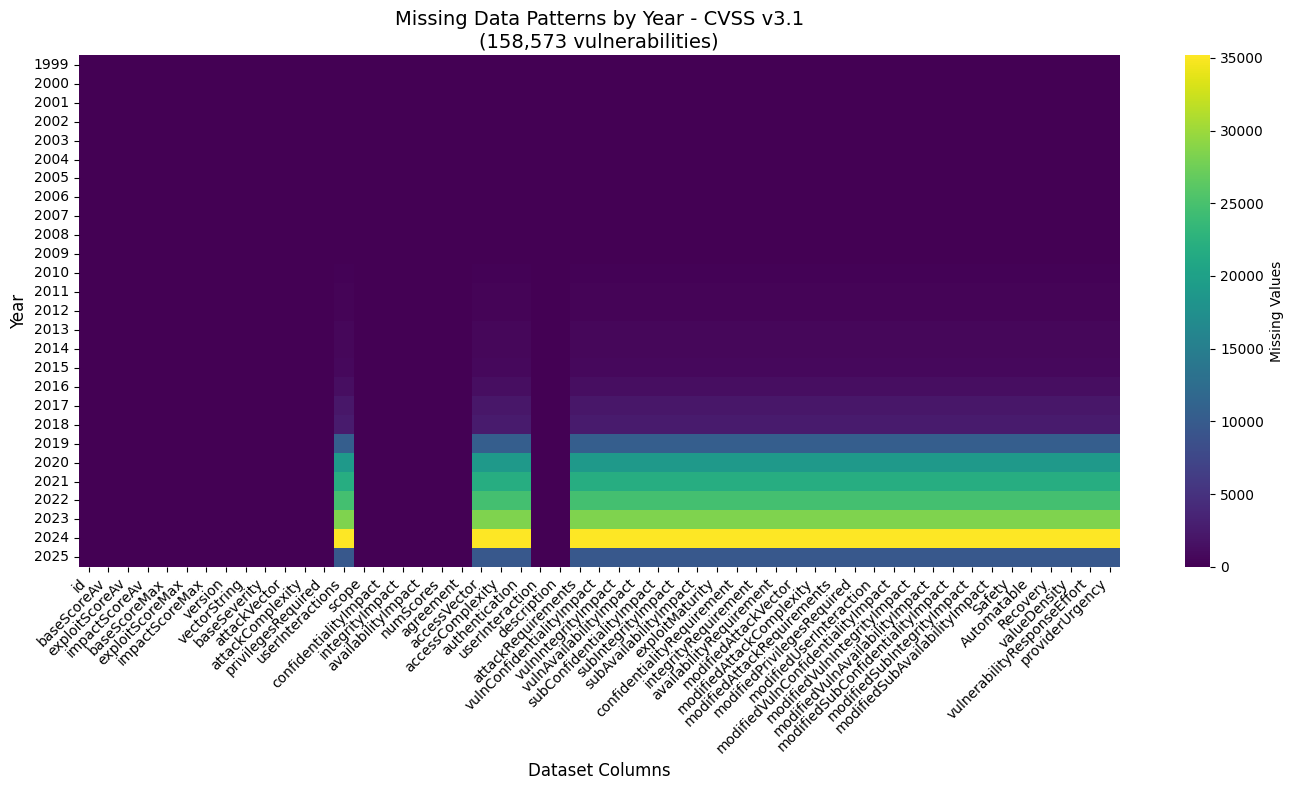

Generating missing data heatmap for CVSS v4.0...


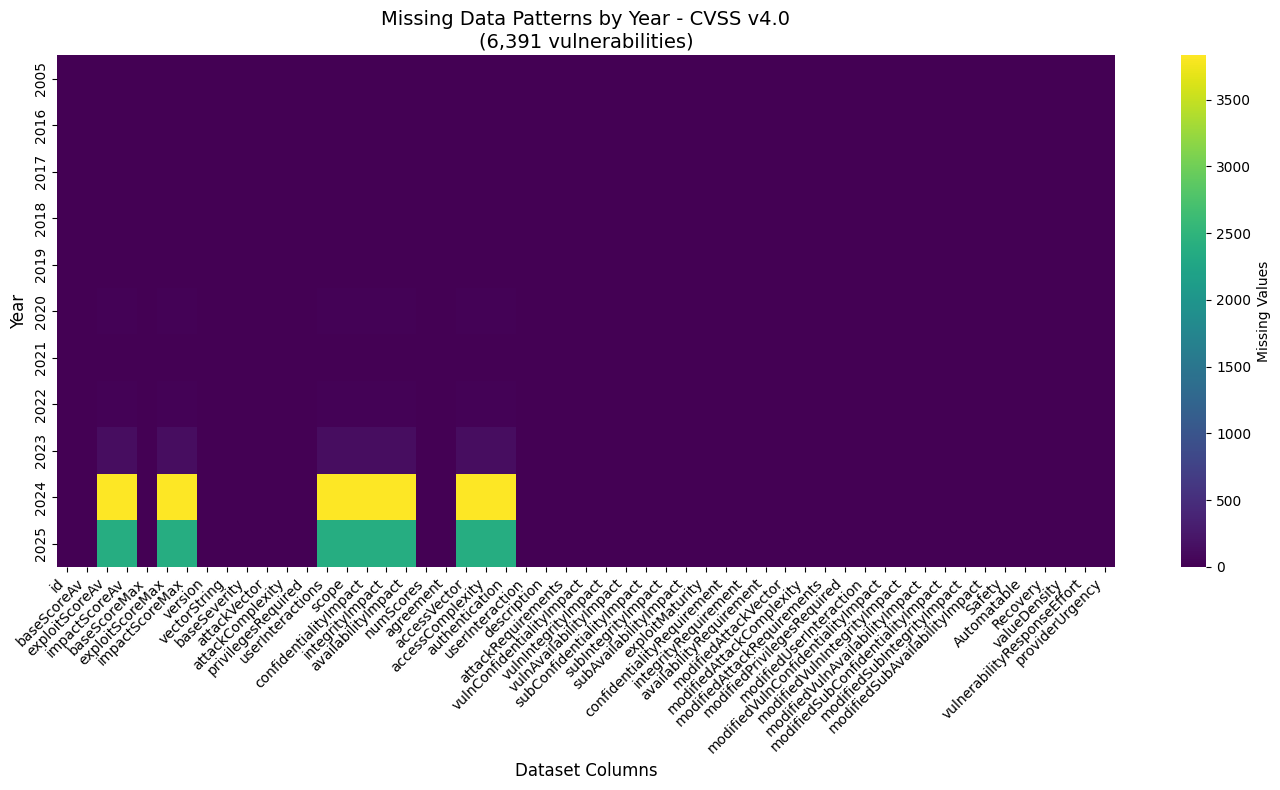

Version-specific missing data analysis complete!


In [ ]:
# Generate heatmaps for each CVSS version to understand missing data patterns
for version, subset_df in version_datasets.items():
    print(f"Generating missing data heatmap for CVSS v{version}...")

    # Group by year and count missing values
    # Include include_groups=False to address the DeprecationWarning
    null_counts_by_year = subset_df.groupby('year').apply(lambda x: x.isnull().sum(), include_groups=False)

    # Create the heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(null_counts_by_year, cmap='viridis', cbar_kws={'label': 'Missing Values'})

    # Set the title based on the version name
    plt.title(f'Missing Data Patterns by Year - CVSS v{version}\n({len(subset_df):,} vulnerabilities)', fontsize=14)
    plt.xlabel('Dataset Columns', fontsize=12)
    plt.ylabel('Year', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot for the current DataFrame
    plt.show()

print("Version-specific missing data analysis complete!")

In [ ]:
# Display dataset dimensions for each CVSS version
print("Dataset Dimensions by CVSS Version:")
print("-" * 40)
for version, subset_df in version_datasets.items():
    rows, cols = subset_df.shape
    print(f'CVSS v{version:3}: {rows:,} vulnerabilities × {cols} features')

# Calculate distribution percentages
total_vulns = sum(len(subset_df) for subset_df in version_datasets.values())
print(f"\nTotal vulnerabilities across all versions: {total_vulns:,}")
print("\nDistribution by version:")
for version, subset_df in version_datasets.items():
    percentage = (len(subset_df) / total_vulns) * 100
    print(f'CVSS v{version}: {percentage:.1f}%')

Dataset Dimensions by CVSS Version:
----------------------------------------
CVSS v2.0: 186,366 vulnerabilities × 54 features
CVSS v3.0: 53,460 vulnerabilities × 54 features
CVSS v3.1: 158,573 vulnerabilities × 54 features
CVSS v4.0: 6,391 vulnerabilities × 54 features

Total vulnerabilities across all versions: 404,790

Distribution by version:
CVSS v2.0: 46.0%
CVSS v3.0: 13.2%
CVSS v3.1: 39.2%
CVSS v4.0: 1.6%


In [ ]:
# Analyze missing values for each CVSS version
print("Missing Values Analysis by CVSS Version:")
print("=" * 50)

for version, subset_df in version_datasets.items():
    print(f'\nCVSS v{version} Missing Values:')
    print("-" * 30)
    
    null_counts = subset_df.isnull().sum()
    
    # Show only columns with missing values
    missing_cols = null_counts[null_counts > 0]
    
    if len(missing_cols) > 0:
        print(f"Columns with missing data: {len(missing_cols)}")
        for col, count in missing_cols.items():
            percentage = (count / len(subset_df)) * 100
            print(f"  {col}: {count:,} ({percentage:.1f}%)")
    else:
        print("No missing values in this version")
    
    # Show completeness summary
    total_cells = len(subset_df) * len(subset_df.columns)
    missing_cells = null_counts.sum()
    completeness = ((total_cells - missing_cells) / total_cells) * 100
    print(f"Overall completeness: {completeness:.1f}%")

Missing Values Analysis by CVSS Version:

CVSS v2.0 Missing Values:
------------------------------
Columns with missing data: 35
  baseSeverity: 186,366 (100.0%)
  attackVector: 186,366 (100.0%)
  attackComplexity: 186,366 (100.0%)
  privilegesRequired: 186,366 (100.0%)
  userInteractions: 186,366 (100.0%)
  scope: 186,366 (100.0%)
  userInteraction: 186,366 (100.0%)
  attackRequirements: 186,366 (100.0%)
  vulnConfidentialityImpact: 186,366 (100.0%)
  vulnIntegrityImpact: 186,366 (100.0%)
  vulnAvailabilityImpact: 186,366 (100.0%)
  subConfidentialityImpact: 186,366 (100.0%)
  subIntegrityImpact: 186,366 (100.0%)
  subAvailabilityImpact: 186,366 (100.0%)
  exploitMaturity: 186,366 (100.0%)
  confidentialityRequirement: 186,366 (100.0%)
  integrityRequirement: 186,366 (100.0%)
  availabilityRequirement: 186,366 (100.0%)
  modifiedAttackVector: 186,366 (100.0%)
  modifiedAttackComplexity: 186,366 (100.0%)
  modifiedAttackRequirements: 186,366 (100.0%)
  modifiedPrivilegesRequired: 186,3

In [ ]:
# Analyze unique values for each CVSS version to understand data diversity
print("Unique Values Analysis by CVSS Version:")
print("=" * 50)

for version, subset_df in version_datasets.items():
    print(f'\nCVSS v{version} Unique Values:')
    print("-" * 30)
    
    unique_counts = subset_df.nunique()
    
    # Show key columns with their unique value counts
    key_columns = ['baseScoreAv', 'exploitScoreAv', 'impactScoreAv', 'description']
    for col in key_columns:
        if col in unique_counts.index:
            print(f"  {col}: {unique_counts[col]:,} unique values")
    
    print(f"  Total unique CVE IDs: {unique_counts['id']:,}")
    print(f"  Total features: {len(unique_counts)}")
    
    # Show data diversity ratio
    diversity_ratio = unique_counts['id'] / len(subset_df)
    print(f"  Data diversity: {diversity_ratio:.1%} (higher = more diverse)")

Unique Values Analysis by CVSS Version:

CVSS v2.0 Unique Values:
------------------------------
  baseScoreAv: 77 unique values
  exploitScoreAv: 24 unique values
  impactScoreAv: 10 unique values
  description: 180,129 unique values
  Total unique CVE IDs: 186,366
  Total features: 54
  Data diversity: 100.0% (higher = more diverse)

CVSS v3.0 Unique Values:
------------------------------
  baseScoreAv: 181 unique values
  exploitScoreAv: 71 unique values
  impactScoreAv: 56 unique values
  description: 50,883 unique values
  Total unique CVE IDs: 53,460
  Total features: 54
  Data diversity: 100.0% (higher = more diverse)

CVSS v3.1 Unique Values:
------------------------------
  baseScoreAv: 274 unique values
  exploitScoreAv: 109 unique values
  impactScoreAv: 106 unique values
  description: 149,353 unique values
  Total unique CVE IDs: 158,573
  Total features: 54
  Data diversity: 100.0% (higher = more diverse)

CVSS v4.0 Unique Values:
------------------------------
  baseScor

## Cross-Version Data Integration

To create a comprehensive dataset that leverages information from all CVSS versions, we need to merge the version-specific datasets. This process involves:

1. **Data Cleaning**: Remove columns with all null values from each version
2. **Column Renaming**: Add version suffixes to distinguish between versions
3. **Outer Join**: Merge all datasets on CVE ID to preserve all vulnerabilities
4. **Conflict Resolution**: Handle cases where the same CVE appears in multiple versions

This integrated dataset will allow us to:
- Compare scoring across different CVSS versions for the same vulnerabilities
- Utilize the most complete information available for each CVE
- Prepare comprehensive features for machine learning models


In [ ]:
# Create integrated dataset by merging all CVSS version datasets
from functools import reduce

print("Creating integrated cross-version dataset...")
print("Step 1: Cleaning and renaming version-specific datasets")

# Container to hold cleaned and renamed DataFrames
cleaned_renamed_subsets = []

for version, subset_df in version_datasets.items():
    print(f"\nProcessing CVSS v{version}:")
    
    # Drop columns with any null values to focus on complete data
    cols_before = len(subset_df.columns)
    cleaned_df = subset_df.dropna(axis=1)
    cols_after = len(cleaned_df.columns)
    print(f"  Removed {cols_before - cols_after} columns with missing values")
    print(f"  Kept {cols_after} complete columns")

    # Rename columns to include version suffix, except 'id' (used for merging)
    renamed_columns = {
        col: f"{col}_v{version}" for col in cleaned_df.columns if col != 'id'
    }
    cleaned_df = cleaned_df.rename(columns=renamed_columns)
    
    print(f"  Added version suffix to {len(renamed_columns)} columns")
    cleaned_renamed_subsets.append(cleaned_df)

print(f"\nStep 2: Merging {len(cleaned_renamed_subsets)} datasets...")

# Merge all cleaned and renamed DataFrames on 'id' using outer join
# This preserves all vulnerabilities from all versions
merged_df = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), cleaned_renamed_subsets)

print(f"\nIntegrated dataset created:")
print(f"  Total vulnerabilities: {len(merged_df):,}")
print(f"  Total features: {len(merged_df.columns):,}")
print(f"  Memory usage: {merged_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display sample of merged data
print("\nSample of integrated dataset:")
print(merged_df.head())

Creating integrated cross-version dataset...
Step 1: Cleaning and renaming version-specific datasets

Processing CVSS v2.0:
  Removed 35 columns with missing values
  Kept 19 complete columns
  Added version suffix to 18 columns

Processing CVSS v3.0:
  Removed 32 columns with missing values
  Kept 22 complete columns
  Added version suffix to 21 columns

Processing CVSS v3.1:
  Removed 32 columns with missing values
  Kept 22 complete columns
  Added version suffix to 21 columns

Processing CVSS v4.0:
  Removed 12 columns with missing values
  Kept 42 complete columns
  Added version suffix to 41 columns

Step 2: Merging 4 datasets...

Integrated dataset created:
  Total vulnerabilities: 275,234
  Total features: 102
  Memory usage: 862.7 MB

Sample of integrated dataset:
              id  baseScoreAv_v2.0  exploitScoreAv_v2.0  impactScoreAv_v2.0  \
0  CVE-1999-0001               5.0                 10.0                 2.9   
1  CVE-1999-0002              10.0                 10.0   

In [ ]:
# Verify data integrity of merged dataset
unique_cves = merged_df['id'].nunique()
total_records = len(merged_df)

print(f"Integrated Dataset Integrity Check:")
print(f"Unique CVE IDs: {unique_cves:,}")
print(f"Total records: {total_records:,}")

if unique_cves == total_records:
    print("✓ Perfect integrity: Each CVE appears exactly once")
else:
    print("⚠ Data integrity issue: Some CVEs may appear multiple times")
    
print(f"\nCoverage: {unique_cves:,} unique vulnerabilities across all CVSS versions")

Integrated Dataset Integrity Check:
Unique CVE IDs: 275,234
Total records: 275,234
✓ Perfect integrity: Each CVE appears exactly once

Coverage: 275,234 unique vulnerabilities across all CVSS versions


In [ ]:
# Confirm total record count
print(f"Total records in integrated dataset: {len(merged_df):,}")
print(f"This represents {len(merged_df):,} vulnerability records with cross-version information")

Total records in integrated dataset: 275,234
This represents 275,234 vulnerability records with cross-version information


In [ ]:
# Display integrated dataset dimensions
rows, cols = merged_df.shape
print(f"Integrated Dataset Dimensions:")
print(f"Rows (vulnerabilities): {rows:,}")
print(f"Columns (features): {cols:,}")
print(f"Total data points: {rows * cols:,}")

# Calculate data density (non-null values)
total_cells = rows * cols
non_null_cells = merged_df.count().sum()
data_density = (non_null_cells / total_cells) * 100
print(f"Data density: {data_density:.1f}% (non-null values)")

Integrated Dataset Dimensions:
Rows (vulnerabilities): 275,234
Columns (features): 102
Total data points: 28,073,868
Data density: 29.7% (non-null values)


In [ ]:
# Analyze missing values in the integrated dataset
print("Missing Values Analysis - Integrated Dataset:")
print("=" * 50)

null_counts = merged_df.isnull().sum()
print(f"Total features: {len(null_counts)}")
print(f"Features with missing values: {len(null_counts[null_counts > 0])}")
print(f"Features with complete data: {len(null_counts[null_counts == 0])}")

# Show top 10 features with most missing values
print("\nTop 10 features with most missing values:")
top_missing = null_counts.nlargest(10)
for feature, missing_count in top_missing.items():
    percentage = (missing_count / len(merged_df)) * 100
    print(f"  {feature}: {missing_count:,} ({percentage:.1f}%)")

# Show features with complete data
complete_features = null_counts[null_counts == 0]
print(f"\nFeatures with complete data ({len(complete_features)}):")
for feature in complete_features.index[:10]:  # Show first 10
    print(f"  {feature}")
if len(complete_features) > 10:
    print(f"  ... and {len(complete_features) - 10} more")

Missing Values Analysis - Integrated Dataset:
Total features: 102
Features with missing values: 101
Features with complete data: 1

Top 10 features with most missing values:
  baseScoreAv_v4.0: 268,843 (97.7%)
  baseScoreMax_v4.0: 268,843 (97.7%)
  version_v4.0: 268,843 (97.7%)
  vectorString_v4.0: 268,843 (97.7%)
  baseSeverity_v4.0: 268,843 (97.7%)
  attackVector_v4.0: 268,843 (97.7%)
  attackComplexity_v4.0: 268,843 (97.7%)
  privilegesRequired_v4.0: 268,843 (97.7%)
  numScores_v4.0: 268,843 (97.7%)
  agreement_v4.0: 268,843 (97.7%)

Features with complete data (1):
  id


In [ ]:
# Display all feature names in the integrated dataset
print("Feature Names in Integrated Dataset:")
print("=" * 40)

# Group columns by CVSS version
version_columns = {}
for col in merged_df.columns:
    if col == 'id':
        version_columns['core'] = version_columns.get('core', []) + [col]
    elif '_v' in col:
        version = col.split('_v')[-1]
        version_columns[f'v{version}'] = version_columns.get(f'v{version}', []) + [col]
    else:
        version_columns['other'] = version_columns.get('other', []) + [col]

for version, cols in version_columns.items():
    print(f"\n{version.upper()} Features ({len(cols)}):")
    for col in cols[:5]:  # Show first 5 columns
        print(f"  {col}")
    if len(cols) > 5:
        print(f"  ... and {len(cols) - 5} more")

print(f"\nTotal features: {len(merged_df.columns)}")

Feature Names in Integrated Dataset:

CORE Features (1):
  id

V2.0 Features (18):
  baseScoreAv_v2.0
  exploitScoreAv_v2.0
  impactScoreAv_v2.0
  baseScoreMax_v2.0
  exploitScoreMax_v2.0
  ... and 13 more

V3.0 Features (21):
  baseScoreAv_v3.0
  exploitScoreAv_v3.0
  impactScoreAv_v3.0
  baseScoreMax_v3.0
  exploitScoreMax_v3.0
  ... and 16 more

V3.1 Features (21):
  baseScoreAv_v3.1
  exploitScoreAv_v3.1
  impactScoreAv_v3.1
  baseScoreMax_v3.1
  exploitScoreMax_v3.1
  ... and 16 more

V4.0 Features (41):
  baseScoreAv_v4.0
  baseScoreMax_v4.0
  version_v4.0
  vectorString_v4.0
  baseSeverity_v4.0
  ... and 36 more

Total features: 102


## Target Labeling for Machine Learning

To prepare our dataset for machine learning models, we need to create target labels that indicate which vulnerabilities are known to be exploited in the wild. We'll use the **CISA Known Exploited Vulnerabilities (KEV) catalog** as our ground truth.

### About the KEV Catalog
The CISA KEV catalog contains vulnerabilities that:
- Have evidence of active exploitation
- Pose significant risk to federal enterprise infrastructure
- Are prioritized for remediation

### Target Variable Creation
We'll create a binary target variable where:
- **1 (Positive)**: Vulnerability is in the KEV catalog (known exploited)
- **0 (Negative)**: Vulnerability is not in the KEV catalog (unknown exploitation status)

This labeling approach enables us to build models that can predict which vulnerabilities are likely to be exploited based on their technical characteristics.


In [ ]:
merged_df.drop(columns=['year_v4.0', 'year_v3.0', 'year_v3.1'], inplace=True)

/var/folders/f4/0fj7b3nx5nsbzrqrpd58r8br0000gn/T/ipykernel_76767/2304386863.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_null_counts_by_year = merged_df.groupby('year_v2.0').apply(lambda x: x.isnull().sum())


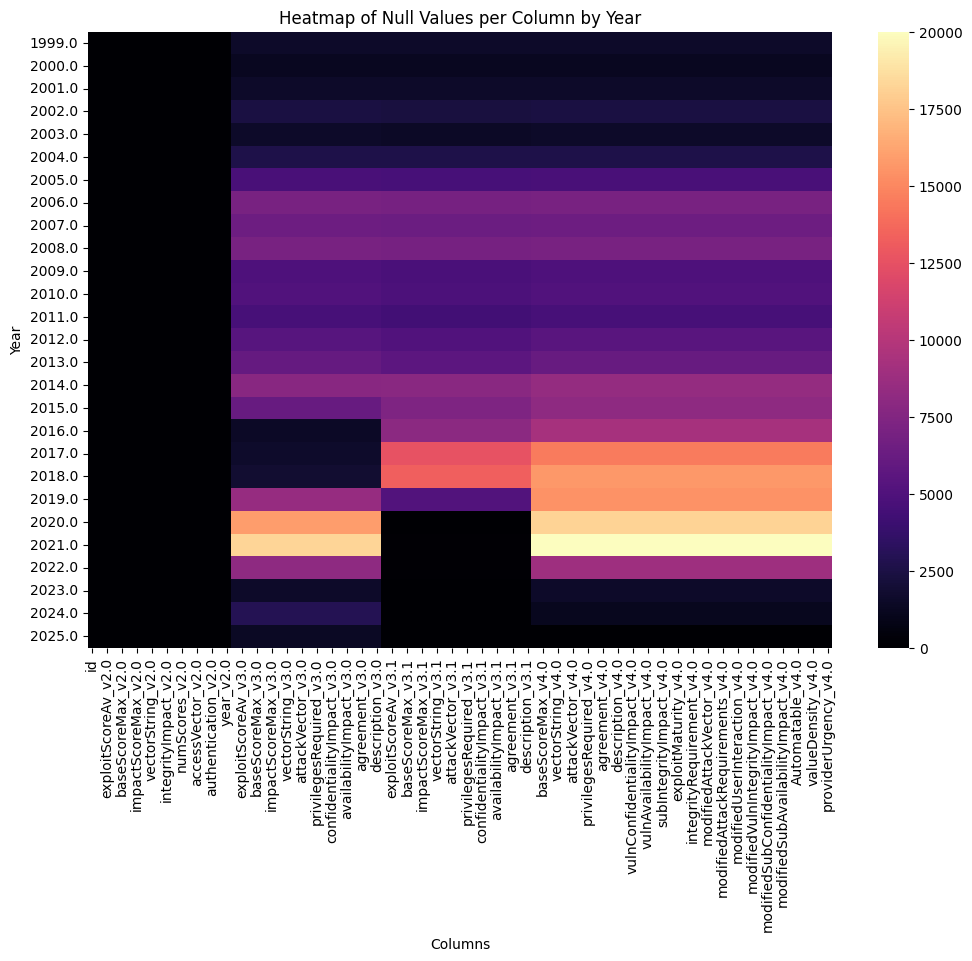

In [ ]:
# Group by year and count nulls
merged_null_counts_by_year = merged_df.groupby('year_v2.0').apply(lambda x: x.isnull().sum())

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(merged_null_counts_by_year, cmap='magma')
plt.title('Heatmap of Null Values per Column by Year')
plt.xlabel('Columns')
plt.ylabel('Year')
plt.show()

In [ ]:
# Show all columns in the DataFrame
pd.set_option('display.max_columns', None)

merged_df.columns

Index(['id', 'baseScoreAv_v2.0', 'exploitScoreAv_v2.0', 'impactScoreAv_v2.0',
       'baseScoreMax_v2.0', 'exploitScoreMax_v2.0', 'impactScoreMax_v2.0',
       'version_v2.0', 'vectorString_v2.0', 'confidentialityImpact_v2.0',
       'integrityImpact_v2.0', 'availabilityImpact_v2.0', 'numScores_v2.0',
       'agreement_v2.0', 'accessVector_v2.0', 'accessComplexity_v2.0',
       'authentication_v2.0', 'description_v2.0', 'year_v2.0',
       'baseScoreAv_v3.0', 'exploitScoreAv_v3.0', 'impactScoreAv_v3.0',
       'baseScoreMax_v3.0', 'exploitScoreMax_v3.0', 'impactScoreMax_v3.0',
       'version_v3.0', 'vectorString_v3.0', 'baseSeverity_v3.0',
       'attackVector_v3.0', 'attackComplexity_v3.0', 'privilegesRequired_v3.0',
       'scope_v3.0', 'confidentialityImpact_v3.0', 'integrityImpact_v3.0',
       'availabilityImpact_v3.0', 'numScores_v3.0', 'agreement_v3.0',
       'userInteraction_v3.0', 'description_v3.0', 'baseScoreAv_v3.1',
       'exploitScoreAv_v3.1', 'impactScoreAv_v3.1', 'ba